In [1]:
"""
Train FBPUNetReconstructor on 'lodopab'.
"""
import numpy as np
from dival import get_standard_dataset
from dival.measure import PSNR
from dival.reconstructors.fbpunet_reconstructor import FBPUNetReconstructor
from dival.datasets.fbp_dataset import (
    generate_fbp_cache_files, get_cached_fbp_dataset)
from dival.reference_reconstructors import (
    check_for_params, download_params, get_hyper_params_path)
from dival.util.plot import plot_images

from torchvision.datasets import MNIST
from fit.datamodules.GroundTruthDataset import GroundTruthDataset
from fit.datamodules.tomo_rec.TRecDataModule import get_projection_dataset

from fit.datamodules.tomo_rec.TRecDataModule import MNISTTomoFourierTargetDataModule
from fit.utils.utils import PSNR, denormalize

import torch

In [2]:
root_dir = '/home/tbuchhol/data/mnist/'
num_angles = 15
IMPL = 'astra_cpu'

In [3]:
dm = MNISTTomoFourierTargetDataModule(root_dir='/data/mnist/', batch_size=32, num_angles=15)
dm.setup()

In [4]:
ray_trafo = dm.gt_ds.get_ray_trafo(impl=IMPL)

In [5]:
LOG_DIR = './dival_logs/mnist_fbpunet'
SAVE_BEST_LEARNED_PARAMS_PATH = './dival_params/mnist_fbpunet'

In [6]:
reconstructor = FBPUNetReconstructor(
    ray_trafo, log_dir=LOG_DIR,
    save_best_learned_params_path=SAVE_BEST_LEARNED_PARAMS_PATH)

In [7]:
reconstructor.hyper_params

{'epochs': 20,
 'batch_size': 64,
 'lr': 0.001,
 'normalize_by_opnorm': False,
 'scales': 5,
 'skip_channels': 4,
 'channels': (32, 32, 64, 64, 128, 128),
 'filter_type': 'Hann',
 'frequency_scaling': 1.0,
 'use_sigmoid': False,
 'init_bias_zero': True,
 'scheduler': 'cosine',
 'lr_min': 0.0001}

In [8]:
reconstructor.hyper_params['scales'] = 4
reconstructor.hyper_params['skip_channels'] = 3

In [9]:
reconstructor.init_model()

In [10]:
reconstructor.model

DataParallel(
  (module): UNet(
    (down): ModuleList(
      (0): DownBlock(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): LeakyReLU(negative_slope=0.2, inplace=True)
        )
      )
      (1): DownBlock(
        (conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.2, inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [12]:
count_parameters(reconstructor.model)

273614

In [16]:
#%% train
# reduce the batch size here if the model does not fit into GPU memory
# reconstructor.batch_size = 16
reconstructor.train(dm.gt_ds)

/home/tbuchhol/Programs/miniconda3/envs/ft/lib/python3.7/site-packages/dival/reconstructors/fbpunet_reconstructor.py:100: UserWarning: Dataset does not support random access. Shuffling will not work, and only 1 worker will be used for data loading.
  warn('Dataset does not support random access. Shuffling will not '
epoch 20: 100%|██████████| 79/79 [00:16<00:00,  4.74it/s, phase=validation, loss=0.00773, psnr=32.5]

Best val psnr: 32.717476


In [17]:
reconstructor.load_learned_params('dival_params/mnist_fbpunet.pt')

In [28]:
#%% evaluate
test = dm.gt_ds.get_test_generator()
recos = []
psnrs = []
for obs, gt in test:
    reco = reconstructor.reconstruct(obs)
    recos.append(reco)
    psnrs.append(PSNR(denormalize(gt, dm.mean, dm.std), 
                      denormalize(torch.from_numpy(reco.asarray()), dm.mean, dm.std), 
                      drange=torch.tensor(255., dtype=torch.float32)))

In [29]:
print('mean psnr: {:2.3f}; SEM: {:2.3f}'.format(np.mean(psnrs), np.std(psnrs)/np.sqrt(len(psnrs))))

mean psnr: 32.791; SEM: 0.023


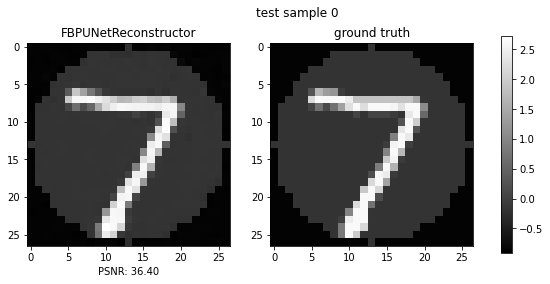

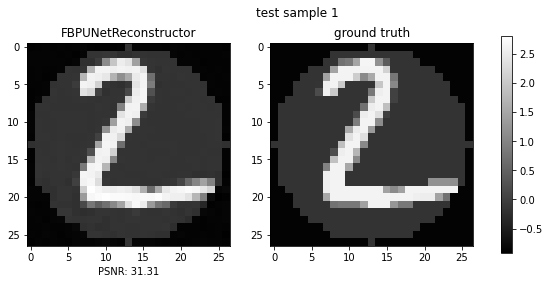

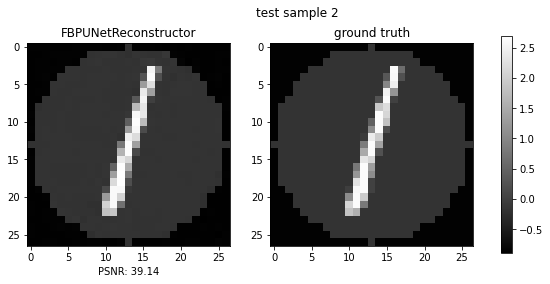

In [30]:
for i, (obs, gt) in zip(range(3), dm.gt_ds.get_test_generator()):
    _, ax = plot_images([recos[i].asarray().T, gt.T],
                        fig_size=(10, 4))
    ax[0].set_xlabel('PSNR: {:.2f}'.format(psnrs[i]))
    ax[0].set_title('FBPUNetReconstructor')
    ax[1].set_title('ground truth')
    ax[0].figure.suptitle('test sample {:d}'.format(i))